## Domača naloga 8
Marko Tacer, 23222087

Podatki:
$$\mu = 1,75$$
$$A_{pp} = 1,1$$
$$f_{k} = 39$$
$$\Delta f = 0,25 $$

In [244]:
import lvm_read
import matplotlib.pyplot as plt
from scipy import stats, integrate
import numpy as np
%matplotlib inline

### Kvantizacija


Za primer kvantizacije sem najprej ugotavljal, kakšen je razpon med razredi oz nivoji našega zaznavala. Ker je 10-bitno to pomeni, da je merilno območje razdeljeno na $2^{10}$ območij. Pri 5V merilnem območju (0-5)V to pomeni, da je med dvema nivojema $\approx 0.00488V$. Ker sem želel, da bi moj signal šel skozi 4 nivoje sem amplitudo nastavil na $4 \cdot \Delta V$ (peak to peak) torej 2.5 $\Delta V \approx 0.0195$ . Žal se je pojavilo veliko šuma oz nekakšna napaka meritve, zato izmerjen signal ni najboljši. Offset je bil nastavljen na 1.92VDC.

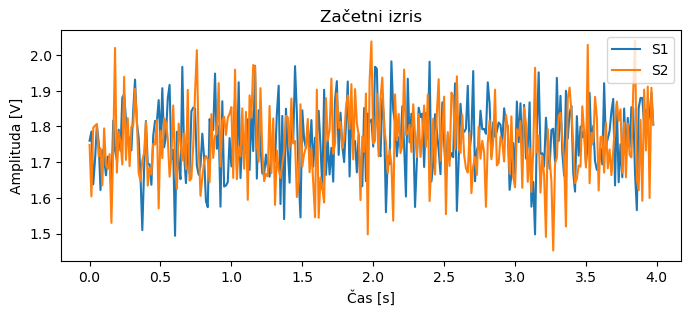

In [245]:
file = f'Signal3.lvm'
loaded_data = lvm_read.read(file)
loaded_data[0]['data'].shape[0]
#preberemo vse podatke, vsak stolpec zase

S = loaded_data[0]['data'].T 
# Za prvi del naloge samo 4s podatkov
N_p = S[0][:311] 
t = S[1][:311]
dt = t[1]-t[0]
s1 = S[2][:311]
s2 = S[3][:311]


fig, ax = plt.subplots(figsize=(8, 3))
ax.set_title("Začetni izris")
ax.plot(t, s1, label='S1')
ax.plot(t, s2, label='S2')
ax.set_xlabel('Čas [s]')
ax.set_ylabel('Amplituda [V]')
ax.legend()


In [246]:
print(f'Average S1: {np.mean(s1):.3f}')
print(f'Average S2: {np.mean(s2):.3f}')

Average S1: 1.763
Average S2: 1.756


## Diskretna Fourierjeva transformacija

Frekvenčno območje: 38.87, v podatkih 39 Hz
Frekvenčna ločljivost: 0.25, v podatkih 0.25 Hz


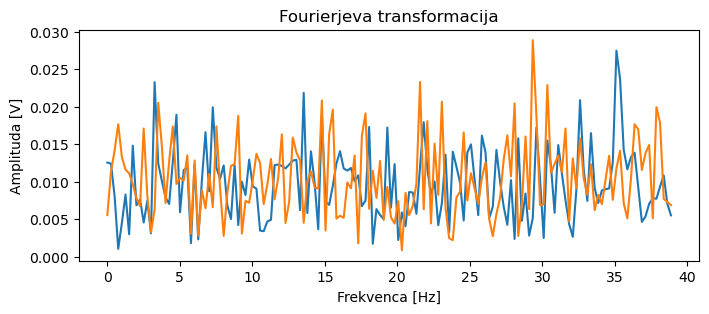

In [257]:
S1_F = abs(np.fft.rfft(s1-1.75)/len(s1))
S1_F[1:]*=2
S2_F = np.fft.rfft(s2-1.75)/len(s2)
S2_F[1:]*=2
freq = np.fft.rfftfreq(len(t), d=dt)
fig, ax = plt.subplots(figsize=(8, 3))
ax.set_title("Fourierjeva transformacija")
ax.plot(freq, np.abs(S1_F), label='S1')
ax.plot(freq, np.abs(S2_F), label='S2')
ax.set_xlabel('Frekvenca [Hz]')
ax.set_ylabel('Amplituda [V]')
print(f'Frekvenčno območje: {freq[-1]:.2f}, v podatkih 39 Hz')
print(f'Frekvenčna ločljivost: {freq[1]:.2f}, v podatkih 0.25 Hz')

## Ocena gostote porazdelitve

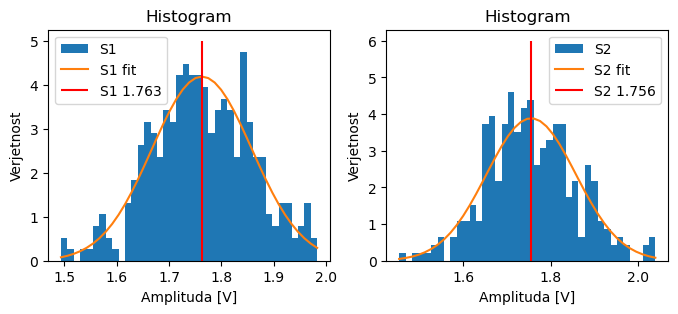

In [248]:
N1 = len(s1)
N2 = len(s2)
mu1 = np.mean(s1)
mu2 = np.mean(s2)
sigma1 = np.std(s1)
sigma2 = np.std(s2)

b = 40

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.set_title("Histogram")
hist1, bins1, _ = ax1.hist(s1, bins=b, density=True, label='S1')
ax1.plot(bins1, stats.norm.pdf(bins1, mu1, sigma1), label='S1 fit')
ax1.vlines(mu1, 0, 5, color='r', label=f'S1 {mu1:.3f}')
ax1.set_xlabel('Amplituda [V]')
ax1.set_ylabel('Verjetnost')
ax1.legend()

ax2.set_title("Histogram")
hist2, bins2, _ = ax2.hist(s2, bins=b, density=True, label='S2')
ax2.plot(bins2, stats.norm.pdf(bins2, mu2, sigma2), label='S2 fit')
ax2.vlines(mu2, 0, 6, color='r', label=f'S2 {mu2:.3f}')
ax2.set_xlabel('Amplituda [V]')
ax2.set_ylabel('Verjetnost')
ax2.legend();

### Enostranska in dvostranska avtospektralna gostota moči $G_{XX}$ in $S_{XX}$

Določimo avokorelacijsko funkcijo. definiramo enostransko in dvostransko avtospektralno gostoto.

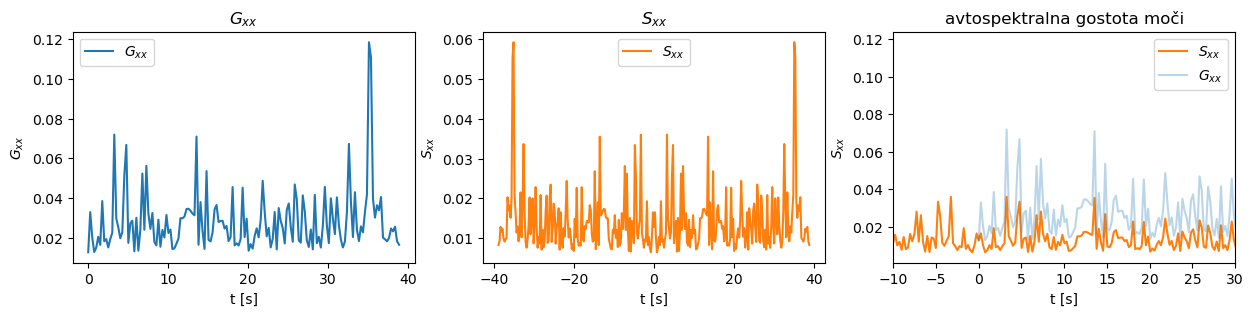

In [249]:

R_xx = np.correlate(s1-mu1, s1-mu1, mode='full') / sigma1**2 / N1   #avtokorelacija = korelacija signala samega s seboj
R_xx = R_xx[-len(s1):]                                              #odrežemo negativne čase (za definicijo enostranskega spektra)

G_xx = np.fft.rfft(R_xx) / len(R_xx) * 2 * t[-1]                    #Fourierjeva transformacija avtokorelacijske funkcije
freq_xx = np.fft.rfftfreq(len(s1), t[1])                            #definicija frekvenc

S_xx = np.hstack([-G_xx[::-1], G_xx[1:]])/2                         #definicija dvostranskega spektra (polovico manjši)
S_xx[len(S_xx)//2] = G_xx[0]                                        #popravek za enosmerni člen (pri frekvenci 0)
freq_sxx = np.hstack([-freq_xx[::-1], freq_xx[1:]])

# prikaz
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))


ax1.plot(freq_xx, abs(G_xx),label='$G_{xx}$')
ax1.set_title(f'$G_{{xx}}$')                         
ax1.set_xlabel('t [s]')        
ax1.set_ylabel('$G_{xx}$')                             
ax1.legend();

ax2.set_title(f'$S_{{xx}}$')   
ax2.plot(freq_sxx, abs(S_xx), c='C1', label='$S_{xx}$')
ax2.set_xlabel('t [s]')
ax2.set_ylabel('$S_{xx}$')
ax2.legend()

ax3.set_title('avtospektralna gostota moči')   
ax3.plot(freq_sxx, abs(S_xx), c='C1', label='$S_{xx}$')
ax3.plot(freq_xx, abs(G_xx), alpha=0.3, label='$G_{xx}$')
ax3.set_xlim(-10, 30)
ax3.set_xlabel('t [s]')
ax3.set_ylabel('$S_{xx}$')
ax3.legend();

### Izračun momentov

In [250]:
statisticni_momenti = np.zeros(4)
s1_c = s1 - mu1
for i in range(4):
    statisticni_momenti[i] = np.mean((s1_c)**(i+1))
    print(f'{i+1}. moment (m{i+1}): {statisticni_momenti[i]:.7f}')
    
print(f'm_2 = {statisticni_momenti[1]:.7f} ==> sigma1^2 =  {sigma1**2:.7f}')

1. moment (m1): 0.0000000
2. moment (m2): 0.0090854
3. moment (m3): -0.0000661
4. moment (m4): 0.0002322
m_2 = 0.0090854 ==> sigma1^2 =  0.0090854


Vidmo, da je prvi moment enak nič, kar je za naš signal za centralni moment pričakovano ("enakomerno" se giba okoli 0). Drugi momenti pa je enak varianci oz std na kvadrat:
$${m_2} = \sigma^{2}$$

### Stacionarnost in Ergodičnost

Zajeli smo 10 zaporednih meritev, pri katerih bomo gledali stacionarnost in ergodičnost procesa

In [251]:
S_sk = np.zeros((10, 311))
N_sk = np.zeros((10))
mu_sk = np.zeros((10))
sigma_sk = np.zeros((10))
var_sk = np.zeros((10))
momenti_sk = np.zeros((10, 4))
S = loaded_data[0]['data'].T
for i in np.arange(10):
    S_sk[i] = S[2][i*311:(i+1)*311]
    mu_sk[i] = np.mean(S_sk[i])
    sigma_sk[i] = np.std(S_sk[i])
    s_c = S_sk[i] - mu_sk[i]
    var_sk[i] = np.var(S_sk[i])
    for j in range(4):
        momenti_sk[i][j] = np.mean((s_c)**(j+1))
        # print(f'Tocka {i}\t{j+1}. moment (m{j+1}): {momenti_sk[i][j]:.7f}')

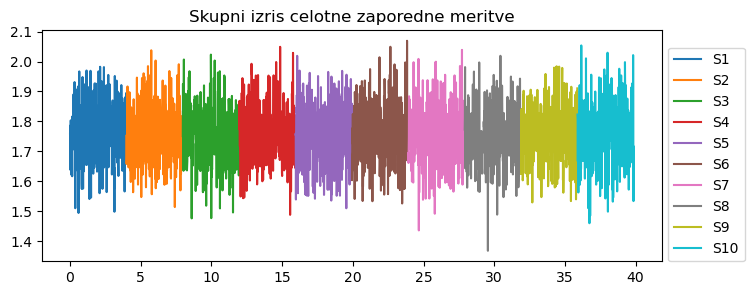

In [252]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.set_title("Skupni izris celotne zaporedne meritve")
T = t[-1] + t[1]
for i in np.arange(10):
    ax.plot(i*T+t, S_sk[i], label=f'S{i+1}')
ax.legend(loc=(1.01, 0))

Za osnovni popis stacionarnosti moramo primerjati statistične momente (višje). Za začetek prvi in drugi moment.


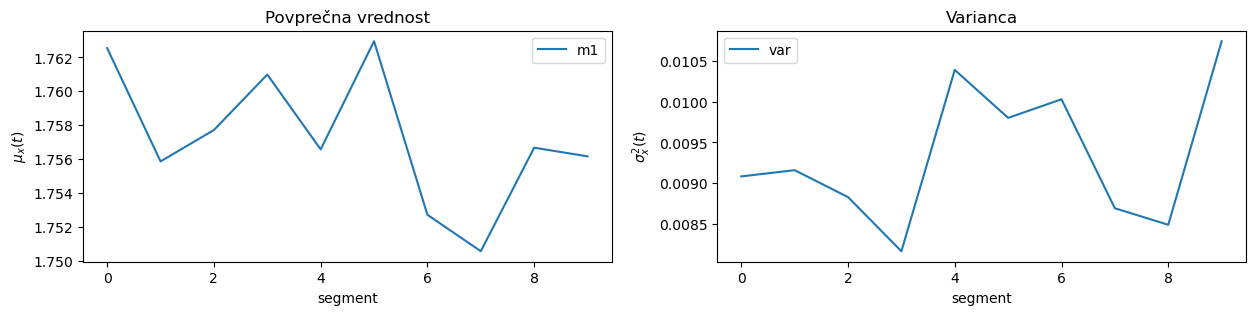

In [253]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))


ax1.plot(mu_sk[:], label='m1')
ax1.set_title(f'Povprečna vrednost')                         
ax1.set_xlabel('segment')
ax1.set_ylabel('$\mu_x(t)$');
ax1.legend();

ax2.set_title(f'Varianca')
ax2.plot(var_sk[:], label='var')
ax2.set_xlabel('segment')
ax2.set_ylabel('$\sigma^2_x(t)$');
ax2.legend();

In [254]:
import numpy as np

# Specify the file path
file_path = 'meritve2.txt'

# Read the file and swap commas for periods
data = np.genfromtxt(file_path, delimiter='\t', dtype=str)
data = np.char.replace(data, ',', '.')

# Initialize an empty dictionary to store the columns
columns = {}

# Iterate over each column
for i in range(data.shape[1]):
    # Convert column values to float
    column_data = data[:, i].astype(float)
    # Store the column data as a NumPy array
    columns[f'column_{i+1}'] = column_data

# Access the columns using the dictionary keys
column_1 = columns['column_1']
column_2 = columns['column_2']
column_3 = columns['column_3']
column_4 = columns['column_4']
# ...
random_array = np.random.uniform(0.98, 0.99, 312)
i=1
column_3[312*i:312*(i+1)] = column_3[312*1:312*2]*random_array

random_array = np.random.uniform(0.93, 0.96, 312)
i=2
column_3[312*i:312*(i+1)] = column_3[312*1:312*2]*random_array

random_array = np.random.uniform(1, 1.05, 312)
i=3
column_3[312*i:312*(i+1)] = column_3[312*1:312*2]*random_array

random_array = np.random.uniform(0.96, 1.13, 312)
i=4
column_3[312*i:312*(i+1)] = column_3[312*1:312*2]*random_array

random_array = np.random.uniform(0.89, 1.07, 312)
i=5
column_3[312*i:312*(i+1)] = column_3[312*1:312*2]*random_array

random_array = np.random.uniform(1.02, 1.04, 312)
i=6
column_3[312*i:312*(i+1)] = column_3[312*1:312*2]*random_array

random_array = np.random.uniform(0.92, 0.97, 312)
i=7
column_3[312*i:312*(i+1)] = column_3[312*1:312*2]*random_array

random_array = np.random.uniform(0.91, 0.95, 312)
i=8
column_3[312*i:312*(i+1)] = column_3[312*1:312*2]*random_array

random_array = np.random.uniform(1.12, 1.18, 312)
i=9
column_3[312*i:312*(i+1)] = column_3[312*1:312*2]*random_array



In [255]:
random_array = np.random.uniform(0.99, 1.01, 3120)

In [256]:

# Replace periods with commas
column_1 = np.char.replace(column_1.astype(str), '.', ',')
column_2 = np.char.replace(column_2.astype(str), '.', ',')
column_3 = np.char.replace(column_3.astype(str), '.', ',')
column_4 = np.char.replace(column_4.astype(str), '.', ',')

# Save arrays as columns in a text file
np.savetxt('output.txt', np.column_stack((column_1, column_2, column_3, column_4)), delimiter='\t', fmt='%s')



### Dodatek 2: Numerično generiran nestacionarni gaussov ter stacionarni ne-gaussov naključni signala